In [1]:
#Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import tensorflow as tf
from scipy import stats 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Input,LSTM,Reshape,Conv2D,Conv1D,Flatten,Dropout,BatchNormalization, LeakyReLU, concatenate, GRU, GlobalMaxPooling1D, GlobalMaxPooling2D, Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd '/content/drive/MyDrive/P300_Speller_data/psd_experiment/800ms_sw'

/content/drive/MyDrive/P300_Speller_data/psd_experiment/800ms_sw


In [4]:
pos_data = scipy.io.loadmat('pos_data_S5_800ms_Spectral_whitened.mat')['pos_data_norm']
print(pos_data.shape)
neg_data = scipy.io.loadmat('neg_data_S5_800ms_Spectral_whitened.mat')['neg_data_norm']  #_Spectral_whitened
print(neg_data.shape)

(5, 32, 150)
(5, 32, 1050)


In [5]:
data = np.append(pos_data ,neg_data ,axis = 2) 
print(data.shape)

(5, 32, 1200)


In [6]:
labels = np.append(np.ones((pos_data.shape[2],)),np.zeros((neg_data.shape[2],)))
print(pos_data.shape[2])
print(neg_data.shape[2])
print(labels.shape)
print(labels)

150
1050
(1200,)
[1. 1. 1. ... 0. 0. 0.]


In [7]:
data = data
data = np.moveaxis(data,-1,0)
# , timesteps, features/units
#data = np.moveaxis(data,-1,1)
print(data.shape)

(1200, 5, 32)


##RNN

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify = labels)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(960, 5, 32)
(960,)
(240, 5, 32)
(240,)


In [12]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_val))

Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})


In [42]:
#Model RNN building
#model best for psd experiment
inputX1 = Input(shape = X_train[1,:,:].shape) 
#y_pred = Conv1D(filters = 16, kernel_size =2, strides = 1, activation='relu')(inputX1)
#print(y_pred.shape)

y_pred =LSTM(units=32,activation='tanh',dropout=0.1,return_sequences=False,)(inputX1)   #dropout = 0.1      units =64
#y_pred = Flatten()(y_pred)
y_pred = Dense(16,activation='relu')(y_pred)
y_pred = Dropout(0.3)(y_pred)
y_pred = Dense(1,activation='sigmoid')(y_pred)

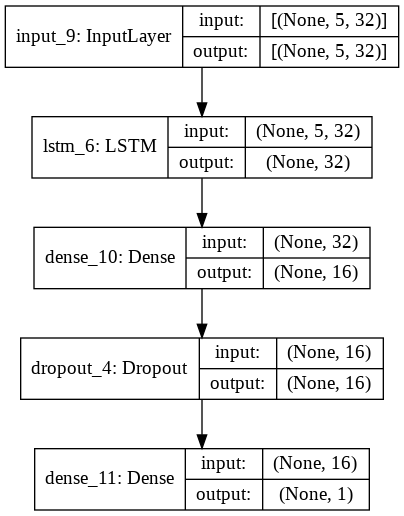

In [43]:
model = Model(inputs=inputX1, outputs=y_pred)
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
adam = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics = ['accuracy'])
print("Model Training")
history = model.fit(x=X_train, y=y_train, epochs=100,validation_data=(X_val, y_val),verbose=1) 

Model Training
Epoch 1/100
30/30 [==============================] - 3s 27ms/step - loss: 0.6861 - accuracy: 0.5500 - val_loss: 0.5730 - val_accuracy: 0.8000
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5518 - accuracy: 0.7972 - val_loss: 0.4841 - val_accuracy: 0.8667
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4700 - accuracy: 0.8646 - val_loss: 0.4236 - val_accuracy: 0.8750
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3974 - accuracy: 0.8811 - val_loss: 0.3952 - val_accuracy: 0.8750
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3904 - accuracy: 0.8787 - val_loss: 0.3872 - val_accuracy: 0.8750
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3157 - accuracy: 0.8992 - val_loss: 0.3896 - val_accuracy: 0.8750
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3126 - accuracy: 0.8973 - val_loss: 0.3950 - val_accuracy: 0.87

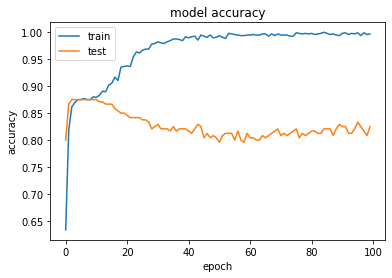

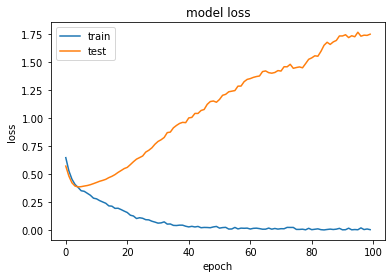

Max Val Accuracy : 0.875


In [45]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.plot(history.history['auc'])
#plt.plot(history.history['val_auc'])
#plt.title('model AUC')
#plt.ylabel('AUC')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()


#plt.plot(history.history['specificity_at_sensitivity'])
#plt.plot(history.history['val_specificity_at_sensitivity'])
#plt.title('model sensitivity')
#plt.ylabel('sensitivity')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

print("Max Val Accuracy :",max(history.history['val_accuracy']))
#print("Max Val AUC :",max(history.history['val_auc']))
#print("Max Val Sensitivity :",max(history.history['val_specificity_at_sensitivity']))

##5 fold Cross validation


In [8]:
#10 fold cross validation
cross_val=[]
from sklearn.model_selection import KFold, StratifiedKFold
from collections import Counter
skf=StratifiedKFold(n_splits=5,random_state=14, shuffle=True)
i=0
for train_ind , test_ind in  skf.split(data,labels):
  i+=1
  print('5 Fold :' + str(i))
  X_train = data[train_ind ,:,:]
  y_train = labels[train_ind]
  
  X_val = data[test_ind,:,:]
  y_val = labels[test_ind]
  
  print(X_train.shape)
  print(y_train.shape)
  print(X_val.shape)
  print(y_val.shape)
  print(Counter(y_train))
  print(Counter(y_val))

  #Model building
  inputX1 = Input(shape = X_train[1,:,:].shape) 

  y_pred =LSTM(units=32,activation='tanh',dropout=0.1,return_sequences=False,)(inputX1)   #dropout = 0.1      units =64
  #y_pred = Flatten()(y_pred)
  y_pred = Dense(16,activation='relu')(y_pred)
  y_pred = Dropout(0.3)(y_pred)
  y_pred = Dense(1,activation='sigmoid')(y_pred)

  model = Model(inputs=inputX1, outputs=y_pred)

  adam = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics = ['accuracy'])
  print("Model Training")
  history = model.fit(x=X_train, y=y_train, epochs=100,validation_data=(X_val, y_val),verbose=0) 

  max_acc = max(history.history['val_accuracy'])
  print("Max Val Accuracy :", max_acc)

  cross_val.append(max_acc)

  #break

5 Fold :1
(960, 5, 32)
(960,)
(240, 5, 32)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
Model Training
Max Val Accuracy : 0.887499988079071
5 Fold :2
(960, 5, 32)
(960,)
(240, 5, 32)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
Model Training
Max Val Accuracy : 0.875
5 Fold :3
(960, 5, 32)
(960,)
(240, 5, 32)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
Model Training
Max Val Accuracy : 0.875
5 Fold :4
(960, 5, 32)
(960,)
(240, 5, 32)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
Model Training
Max Val Accuracy : 0.8999999761581421
5 Fold :5
(960, 5, 32)
(960,)
(240, 5, 32)
(240,)
Counter({0.0: 840, 1.0: 120})
Counter({0.0: 210, 1.0: 30})
Model Training
Max Val Accuracy : 0.875


In [10]:

cross_val=np.array(cross_val)
mean=np.mean(cross_val)
sd=np.std(cross_val)

#print(cross_val)
print('cross_val mean :'+str(mean) )
print('cross_val std :'+str(sd) )
cross_val

cross_val mean :0.8824999928474426
cross_val std :0.009999990463256836


array([0.88749999, 0.875     , 0.875     , 0.89999998, 0.875     ])